# Final project: Stock Prediction

Given the recent stock market history, you will predict the return for ticker AAPL for the day ahead.

# Objectives

You will demonstrate your strengths in several areas, especially
- Exploratory Data Analysis
- Feature Engineering
- Creating, testing and evaluating models
- Error analysis
and Prediction **using Neural Networks**.

Your objective will be to predict next period price returns of a stock given its past prices.

**To be precise**
- given recent prices for AAPL you will predict the next *return*
- *return* will be defined precisely below
- you will be evaluated on a holdout data directory
    - it will have 2 years of data
    - you will be required to predict next period returns for the final 200 days
    - when making a prediction for date $t$, where $t$ is in the holdout data range (**beyond** the last training date)
        - you may use *actual* holdout data for dates strictlty prior to date $t$
        - That is: your prediction for date $t$ *does not* need to be dependent on your *prediction* for date $(t-1)$
    

**Predicting forward returns/prices is hard ! If you could do it well: you would be rich**

Given that fact, out of sample performance will **not** be the sole metric for your grade

This project will test your ability to analyze data, create hypotheses, test them, and improve through iteration.

**You will learn a lot, especially from failures**

This project provides a wealth of opportunity for
- Exploratory data analysis
    - This can suggest several different approaches to building one or more models
- Error Analysis
- Creating, and evaluating models iteratively, learning from past failures and successes.

So your performance will be based on your creativity and experimental process, even if the process
does not lead to great out of sample performance

# The data

As explained in the Final Project Overview:
- you will be given a data directory for training
    - supplied as a compressed archive file in the course's Resource tab in NYU Classes
    - unpacking this file will yield directory `./Data/train`

The data directory will contain one file per ticker, with a history going back many years of fields including
- Price: Close, Open, High, Low
- Volume

"return" means the percent change in the **Close** feature

You will need to 
- decide which files and which fields to use
- prepare the data for training and testing
    - convert from price to return as necessary
    - prepare train and test examples:
    

## Data preparation

- The files contain prices; your goal is to predict a *return* not a price
- Your goal is to predict the **percent change of the Close feature** ("return")
- Your predicted return for day $t$ should be a function of data occuring *before* day $t$

So your first step will be to create a suitable training set.

For example, the following training set is a good starting point:
- each row is an example
- each row will have a column `Dt` indicating time $t$
- each example has *at least* 20 features
    - derived from AAPL features occuring *before* time $t$
- the target for the row with time $t$ should be the *return* of AAPL for date $t$
    - i.e., the percent price change of AAPL from time $t-1$ to time $t$



## Introductory Discussion

- The Problem at hand is a Regression Task where we want to predict the *price return on day $n$* given a series of the features of days $n_{0}, \cdots, n-2, n-1$ preceding the observed.
    - Our performance metric is then *initially* chosen to be the Squared Loss Metric for regression
    - Our initial features include the price returns of a number of days preceding the predicted day. 
    - Our initial model will be standard linear regression as in assignment one (this will just be reference as it doesn't involve neural networks)
    - Our first neural network model to compare with will be the LSTM model which naturally implements a nature of price fluctuation memory
    


## Importing Standard API

In [1]:
import pdb
import pandas as pd
import os
# Standard imports
import numpy as np
import matplotlib.pyplot as plt

import sklearn
import math


%matplotlib inline

## Initial Data Inclusion

Here we import our data and do a simple data processing of only the AAPL adjusted returns

            AAPL_Ret
Dt                  
2005-01-03 -1.723923
2005-01-04  1.027075
2005-01-05  0.875714
2005-01-06  0.077332
2005-01-07  7.281021


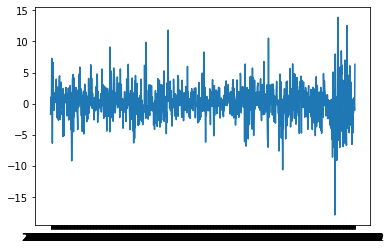

In [2]:
#tickers is a list of tickers
#attrs is a list of data attributes
tickers = ['AAPL']
indx = ""
attrs = ['Adj Close']

##DATA IMPORT
DATA_DIR = './Data/train'
if not os.path.isdir(DATA_DIR):
    DATA_DIR  = "../resource/asnlib/publicdata/data"

dateAttr = "Dt"

use_cols =  attrs.copy()
use_cols.insert(0, dateAttr)

# Read the CSV files
dfs = []
for ticker_num, ticker in enumerate(tickers):
    ticker_file = os.path.join(DATA_DIR, "{t}.csv".format(t=ticker) )
    ticker_df = pd.read_csv(ticker_file, index_col=dateAttr, usecols=use_cols)

    # Rename attributes with ticker name
    rename_map = { orig:  ticker + "_" + orig.replace(" ", "_") for orig in ticker_df.columns.to_list() }
    ticker_df = ticker_df.rename(columns=rename_map)

    dfs.append(ticker_df)


def renamePriceToRet(df, priceAttr = "Adj Close"):
    rename_map = { }
    rename_map = { orig:  orig.replace( priceAttr.replace(" ", "_"), "Ret") for orig in df.columns.to_list() }

    return df.rename(columns = rename_map)


data_df = pd.concat( dfs, axis=1)

start_dt = "2005-01-03"
end_dt = "2009-01-02"

def getReturns(df, start_dt, end_dt):
    '''
    Return the day over day percent changes of adjusted price
    '''
    ## We find start and end index in a similar fashion as before
    start =max(df.index.get_loc(start_dt) - 1,0)
    end = min(df.index.get_loc(end_dt)+1,len(df))
    data = df[start:end]
    return data.pct_change()*100

    
train_data_ret = getReturns(data_df, start_dt, end_dt)
train_data_ret = renamePriceToRet( train_data_ret )
train_data_ret = train_data_ret[start_dt:]
print(train_data_ret.head())
plt.plot(train_data_ret)


## Outlier Detection

We notice from the plot above that there are certain data points that's appear to be outliers and may cause some noise in our training. We replace these outliers with means by using SimpleImputer.

            AAPL_Ret
Dt                  
2005-01-03 -1.723923
2005-01-04  1.027075
2005-01-05  0.875714
2005-01-06  0.077332
2005-01-07  7.281021
...              ...
2008-12-26  0.905350
2008-12-29  0.931916
2008-12-30 -0.368767
2008-12-31 -1.089885
2009-01-02  6.326704

[1008 rows x 1 columns]
Percentiles: 25th=-1.344, 75th=1.741, IQR=3.084
Identified outliers: 35


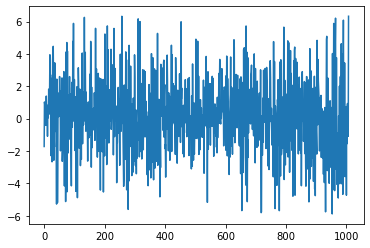

In [3]:
from numpy import percentile
q25, q75 = percentile(train_data_ret, 25), percentile(train_data_ret, 75)
print(train_data_ret)
iqr = q75 - q25
print('Percentiles: 25th=%.3f, 75th=%.3f, IQR=%.3f' % (q25, q75, iqr))
# calculate the outlier cutoff
cut_off = iqr * 1.5
lower, upper = q25 - cut_off, q75 + cut_off
# identify outliers
outliers_id = [i for i in range(len(train_data_ret.index)) if train_data_ret.AAPL_Ret[i] < lower 
               or train_data_ret.AAPL_Ret[i] > upper]
print('Identified outliers: %d' % len(outliers_id))

# remove outliers
for i in range(len(train_data_ret.index)):
    if i in outliers_id:
        train_data_ret.AAPL_Ret[i] = math.nan

#impute outlier values 
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(missing_values= np.nan, strategy='mean')
train_data_ret = imputer.fit_transform(train_data_ret)
#train_data_ret = pd.DataFrame(train_data_ret)
plt.plot(train_data_ret)


## Data Processing

We now need to transform our data so that it can be represented by 20 features representing a lookback period of the last 20 days. 

In [4]:
##Delay - observation to delay timesteps
delay = 1

##Look Back - How many timesteps included
lookback = 20

##Steps - timesteps per sample
steps = 1

## NORMALIZING THE DATA ####################################
#
#
#
        
##Function to transform time-lapse data into training matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:i+look_back]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

## PREPARING DATA ########################################

from sklearn.preprocessing import MinMaxScaler

# normalize the dataset
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_ret = scaler.fit_transform(train_data_ret)
# split into train and test sets
train_size = int(len(train_data_ret) * 0.67)
test_size = len(train_data_ret) - train_size
train, test = train_data_ret[0:train_size,:], train_data_ret[train_size:len(train_data_ret),:]
# reshape into X=t and Y=t+1
X_train, y_train = create_dataset(train, lookback)
X_test, y_test = create_dataset(test, lookback)

#print('X_train:', X_train)
print('X Train Dimensions:', X_train.shape)

#print('y_train:', y_train)
print('y Train Dimensions:', y_train.shape)


X Train Dimensions: (655, 20, 1)
y Train Dimensions: (655, 1)


## Regression Model

We provide a baseline model using regression as to compare our future models with. 

(655, 20) (655, 1)
In-Sample Error:  0.12129902276007834
Out of Sample Error:  0.18636048478965953


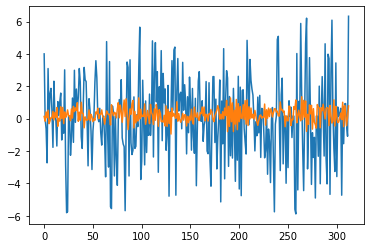

In [5]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error

X_train_reg = X_train.reshape(-1,20)
X_test_reg = X_test.reshape(-1,20)

print(X_train_reg.shape, y_train.shape)
model = linear_model.LinearRegression()
model = model.fit(X_train_reg,y_train)
y_pred = model.predict(X_test_reg)
y_train_pred = model.predict(X_train_reg)
plt.plot(scaler.inverse_transform(y_test))
plt.plot(scaler.inverse_transform(y_pred))
print('In-Sample Error: ', mean_squared_error(y_train_pred,y_train))
print('Out of Sample Error: ', mean_squared_error(y_pred,y_test))


We observe that this model performs somewhat decently (it fails to predict extremely high or low returns) with an in-sample MSE (scaled) of 0.121 and out-sample MSE (scaled) of 0.186

In [6]:
print(model.coef_)

[[ 0.00816951 -0.01536328  0.03294296  0.05096501 -0.05715175 -0.0280105
  -0.02076102  0.01929704  0.00479706  0.02499161 -0.07526965  0.01366172
  -0.07536875 -0.01039846 -0.06332509  0.06458724 -0.02534264  0.0231085
   0.00693141 -0.03286965]]


## GRU Model

We start experimenting with neural networks as required for this finals project. We first explore using GRU model as a natural implementation of RNNs which are suitable in data involving lookback

### Plot Function

In [7]:
def plotTrain(model, history, model_name="???"):
    fig, axs = plt.subplots( 1, 1, figsize=(12, 5) )
    # Plot loss
    axs.plot(history.history['loss'])
    axs.plot(history.history['val_loss'])
    axs.set_title(model_name + " " + 'model loss')
    axs.set_ylabel('loss')
    axs.set_xlabel('epoch')
    axs.legend(['train', 'validation'], loc='upper left')
   
    return fig, axs


X_train_shape (655, 20, 1)
y_train_shape (655, 1)
Epoch 1/10
41/41 [==============================] - 1s 35ms/step - loss: 0.1283 - val_loss: 0.1787
Epoch 2/10
41/41 [==============================] - 1s 12ms/step - loss: 0.1262 - val_loss: 0.1784
Epoch 3/10
41/41 [==============================] - 1s 13ms/step - loss: 0.1268 - val_loss: 0.1784
Epoch 4/10
41/41 [==============================] - 0s 12ms/step - loss: 0.1260 - val_loss: 0.1780
Epoch 5/10
41/41 [==============================] - 0s 12ms/step - loss: 0.1264 - val_loss: 0.1785
Epoch 6/10
41/41 [==============================] - 0s 12ms/step - loss: 0.1261 - val_loss: 0.1784
Epoch 7/10
41/41 [==============================] - 0s 12ms/step - loss: 0.1255 - val_loss: 0.1787
Epoch 8/10
41/41 [==============================] - 0s 12ms/step - loss: 0.1263 - val_loss: 0.1789
Epoch 9/10
41/41 [==============================] - 1s 13ms/step - loss: 0.1258 - val_loss: 0.1782
Epoch 10/10
21/21 [==============================] - 0s 3ms

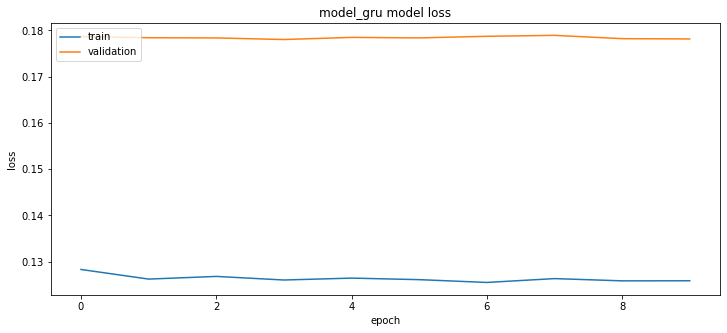

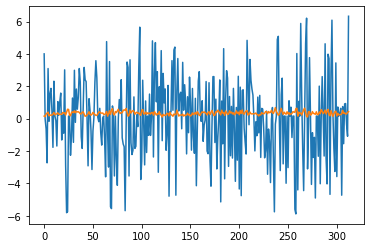

In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU
from keras.optimizers import RMSprop
from keras.layers.core import Dropout
from keras import callbacks
    

print('X_train_shape', X_train.shape)
print('y_train_shape', y_train.shape)

def create_gru(units):
    model = Sequential()
    # Input layer
    model.add(GRU (units = units, return_sequences = True, 
    input_shape = [X_train.shape[1], X_train.shape[2]]))
    model.add(Dropout(0.2)) 
    # Hidden layer
    model.add(GRU(units = units)) 
    model.add(Dropout(0.2))
    model.add(Dense(units = 1)) 
    #Compile model
    model.compile(optimizer='rmsprop',loss='mse')
    return model


model_gru = create_gru(64)
history = model_gru.fit(X_train, y_train, epochs = 10,  
                        validation_data = (X_test, y_test),
                        batch_size = 16, shuffle = False)

score0 = model_gru.evaluate(X_test, y_test)
score1 = model_gru.evaluate(X_train, y_train)

print("{n:s}: Test loss: {l:3.2f}".format(n='LSTM model', l=score0))
print("{n:s}: Train loss: {l:3.2f}".format(n='LSTM model', l=score1))

plotTrain(model_gru, history, 'model_gru')

plt.figure(2)

y_pred = model_gru.predict(X_test)

plt.plot(scaler.inverse_transform(y_test))
plt.plot(scaler.inverse_transform(y_pred))

We observe that the in-sample performance is only about the same as the regression base-line model but the out of sample validation performance is much worse. Graphically, the model doesn't seem to predict much and is very conservative in its predictions. 

In [9]:
print(y_pred.shape)
model_gru.summary()

(313, 1)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 20, 64)            12864     
_________________________________________________________________
dropout (Dropout)            (None, 20, 64)            0         
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                24960     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 37,889
Trainable params: 37,889
Non-trainable params: 0
_________________________________________________________________


## LSTM Model

Here, we experiment with LSTM (Long Short Term Memory) models which appear to be most apt for timeseries data.

In [10]:
X_train_lstm = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
y_test_lstm = np.reshape(y_test, (y_test.shape[0], 1, y_test.shape[1]))

X_test_lstm = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
y_train_lstm = np.reshape(y_train, (y_train.shape[0], 1, y_train.shape[1]))
    
print('X_train_shape', X_train_lstm.shape)
print('y_train_shape', y_train_lstm.shape)

X_train_shape (655, 1, 20)
y_train_shape (655, 1, 1)


Epoch 1/20
655/655 - 1s - loss: 0.1296
Epoch 2/20
655/655 - 1s - loss: 0.1247
Epoch 3/20
655/655 - 1s - loss: 0.1244
Epoch 4/20
655/655 - 0s - loss: 0.1247
Epoch 5/20
655/655 - 1s - loss: 0.1229
Epoch 6/20
655/655 - 1s - loss: 0.1227
Epoch 7/20
655/655 - 1s - loss: 0.1200
Epoch 8/20
655/655 - 1s - loss: 0.1203
Epoch 9/20
655/655 - 1s - loss: 0.1180
Epoch 10/20
655/655 - 1s - loss: 0.1177
Epoch 11/20
655/655 - 1s - loss: 0.1158
Epoch 12/20
655/655 - 1s - loss: 0.1138
Epoch 13/20
655/655 - 1s - loss: 0.1131
Epoch 14/20
655/655 - 1s - loss: 0.1125
Epoch 15/20
655/655 - 1s - loss: 0.1124
Epoch 16/20
655/655 - 1s - loss: 0.1090
Epoch 17/20
655/655 - 1s - loss: 0.1075
Epoch 18/20
655/655 - 1s - loss: 0.1061
Epoch 19/20
655/655 - 1s - loss: 0.1063
Epoch 20/20
655/655 - 1s - loss: 0.1069
Epoch 1/10
41/41 [==============================] - 0s 12ms/step - loss: 0.1003 - val_loss: 0.2055
Epoch 2/10
41/41 [==============================] - 0s 3ms/step - loss: 0.1014 - val_loss: 0.2065
Epoch 3/10
4

(<Figure size 864x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1cc258ec5b0>)

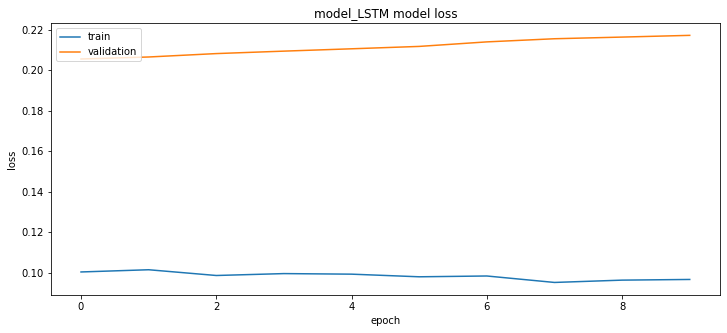

In [11]:
from tensorflow.keras.layers import Dense, LSTM, Dropout
from keras import layers
from keras.models import Sequential
from keras.optimizers import RMSprop
       
model_LSTM = Sequential()
model_LSTM.add(LSTM(units = 50, return_sequences = True, 
                    input_shape=(1, lookback)))
model_LSTM.add(Dropout(0.2))
model_LSTM.add(Dense(1))
model_LSTM.compile(optimizer='rmsprop',loss='mse')
model_LSTM.fit(X_train_lstm, y_train_lstm, epochs=20, batch_size=1, verbose=2)
history = model_LSTM.fit(X_train_lstm, y_train_lstm, epochs = 10,  
                        validation_data = (X_test_lstm, y_test_lstm),
                        batch_size = 16, shuffle = False)
model_LSTM.summary()

score0 = model_LSTM.evaluate(X_test_lstm, y_test_lstm)
score1 = model_LSTM.evaluate(X_train_lstm, y_train_lstm)

print("{n:s}: Test loss: {l:3.2f}".format(n='LSTM model', l=score0))
print("{n:s}: Train loss: {l:3.2f}".format(n='LSTM model', l=score1))
plotTrain(model_LSTM, history, 'model_LSTM')

This model presents a much lower in-sample loss but has a slightly higher out-of-sample loss than our base-line model. While it's hard to necessarily say that this model would perform well on outside data just based on the validation score, the in-sample performance shows that the model is fitting a lot better.

(313, 1)


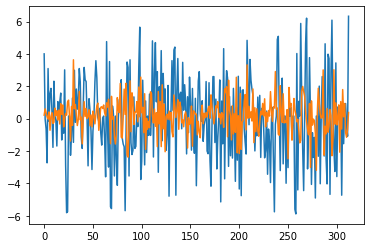

In [12]:
y_pred = model_LSTM.predict(X_test_lstm)
y_pred = y_pred.reshape(-1,1)
print(y_pred.shape)

plt.plot(scaler.inverse_transform(y_test))
plt.plot(scaler.inverse_transform(y_pred))


A graphical view of the model at least proves that the performance is a lot better on an intuitive/functional level as the model is able to better capture larger fluctuations in returns.

### Hyperparameter Tuning (GridSearch)

Before we continue further with feature engineering, we first tune our model's hyperparameters. Here we proceed manually as gridsearch/randomsearch cvs seem very incompatible with our higher dimensional data. 

In [13]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV
import random
from sklearn.metrics import mean_squared_error

def create_model(hparams1 = 1):
    # create model
    model = Sequential()
    model.add(LSTM(units = hparams1, return_sequences = True))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='rmsprop',loss='mse')
    return model

# define the grid search parameters
hparams1 = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 100]
in_sample = []
out_sample = []

for p in hparams1:
    model = create_model(p)
    model.fit(X_train_lstm, y_train_lstm, epochs = 10)
    i = model.evaluate(X_train_lstm, y_train_lstm)
    o = model.evaluate(X_test_lstm, y_test_lstm)
    in_sample.append(i)
    out_sample.append(o)
    print('Neuron numbers: %f has in-sample loss ' %p, i)
    print('Neuron numbers: %f has out-sample loss ' %p, o)




Epoch 1/10
21/21 [==============================] - 0s 1ms/step - loss: 0.1592
Epoch 2/10
21/21 [==============================] - 0s 1ms/step - loss: 0.1448
Epoch 3/10
21/21 [==============================] - 0s 1ms/step - loss: 0.1417
Epoch 4/10
21/21 [==============================] - 0s 1ms/step - loss: 0.1435
Epoch 5/10
21/21 [==============================] - 0s 1ms/step - loss: 0.1382
Epoch 6/10
21/21 [==============================] - 0s 1ms/step - loss: 0.1373
Epoch 7/10
21/21 [==============================] - 0s 1ms/step - loss: 0.1319
Epoch 8/10
21/21 [==============================] - 0s 1ms/step - loss: 0.1327
Epoch 9/10
21/21 [==============================] - 0s 1ms/step - loss: 0.1310
Epoch 10/10
10/10 [==============================] - 0s 800us/step - loss: 0.1837
Neuron numbers: 5.000000 has in-sample loss  0.12616854906082153
Neuron numbers: 5.000000 has out-sample loss  0.18370188772678375
Epoch 1/10
21/21 [==============================] - 0s 1ms/step - loss: 0.12

Neuron numbers: 35.000000 has in-sample loss  0.11916514486074448
Neuron numbers: 35.000000 has out-sample loss  0.18360741436481476
Epoch 1/10
21/21 [==============================] - 0s 1ms/step - loss: 0.1292
Epoch 2/10
21/21 [==============================] - 0s 1ms/step - loss: 0.1257
Epoch 3/10
21/21 [==============================] - 0s 1ms/step - loss: 0.1249
Epoch 4/10
21/21 [==============================] - 0s 1ms/step - loss: 0.1245
Epoch 5/10
21/21 [==============================] - 0s 1ms/step - loss: 0.1236
Epoch 6/10
21/21 [==============================] - 0s 1ms/step - loss: 0.1233
Epoch 7/10
21/21 [==============================] - 0s 1ms/step - loss: 0.1224
Epoch 8/10
21/21 [==============================] - 0s 1ms/step - loss: 0.1209
Epoch 9/10
21/21 [==============================] - 0s 1ms/step - loss: 0.1209
Epoch 10/10
10/10 [==============================] - 0s 600us/step - loss: 0.1851
Neuron numbers: 40.000000 has in-sample loss  0.11926978081464767
Neuron n

21/21 [==============================] - 0s 2ms/step - loss: 0.1222
Epoch 6/10
21/21 [==============================] - 0s 2ms/step - loss: 0.1218
Epoch 7/10
21/21 [==============================] - 0s 2ms/step - loss: 0.1208
Epoch 8/10
21/21 [==============================] - 0s 2ms/step - loss: 0.1208
Epoch 9/10
21/21 [==============================] - 0s 2ms/step - loss: 0.1210
Epoch 10/10
10/10 [==============================] - 0s 800us/step - loss: 0.1875
Neuron numbers: 100.000000 has in-sample loss  0.11861603707075119
Neuron numbers: 100.000000 has out-sample loss  0.187491312623024


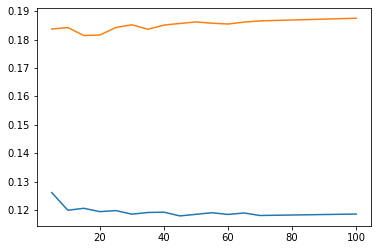

In [14]:
plt.plot(hparams1, in_sample)
plt.plot(hparams1, out_sample)

We note that in consideration of both validation and training performance, taking a hidden neuron layer of about 20 is the optimal for our future training.

## Adding Features

Here I attempted to add two additional features (actually, it's 3 times the number of original features due to the lookback) by the performance of the SP500 over the last 20 days and the spread of the AAPL daily prices over the last 20 days. The reasoning is that the SP500 has a relatively strong correlation with AAPL stock performance (0.6~0.7?) and that the spread represents a daily volatility (so that would be interesting to investigate). 

### Including more Data

            AAPL_Spread   SPY_Ret  AAPL_Ret
Dt                                         
2005-01-03         2.51 -0.471551 -1.723923
2005-01-04         2.50 -1.221897  1.027075
2005-01-05         1.20 -0.690057  0.875714
2005-01-06         1.58  0.508381  0.077332
2005-01-07         4.88 -0.143367  7.281021


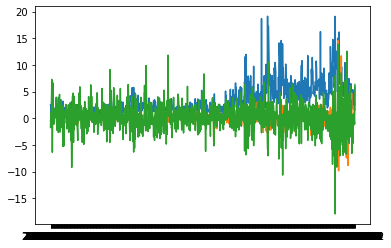

In [15]:
#tickers is a list of tickers
#attrs is a list of data attributes
tickers = ['AAPL', 'SPY']
indx = ""
attrs = ['Adj Close','High','Low']

##DATA IMPORT
DATA_DIR = './Data/train'
if not os.path.isdir(DATA_DIR):
    DATA_DIR  = "../resource/asnlib/publicdata/data"

dateAttr = "Dt"

use_cols =  attrs.copy()
use_cols.insert(0, dateAttr)

# Read the CSV files
dfs = []
for ticker_num, ticker in enumerate(tickers):
    ticker_file = os.path.join(DATA_DIR, "{t}.csv".format(t=ticker) )
    ticker_df = pd.read_csv(ticker_file, index_col=dateAttr, usecols=use_cols)

    # Rename attributes with ticker name
    rename_map = { orig:  ticker + "_" + orig.replace(" ", "_") for orig in ticker_df.columns.to_list() }
    ticker_df = ticker_df.rename(columns=rename_map)

    dfs.append(ticker_df)

data_df = pd.concat( dfs, axis=1)

start_dt = "2005-01-03"
end_dt = "2009-01-02"

def getReturns(df, ticker, start_dt, end_dt):
    '''
    Return the day over day percent changes of adjusted price
    '''
    ## We find start and end index in a similar fashion as before
    start =max(df.index.get_loc(start_dt) - 1,0)
    end = min(df.index.get_loc(end_dt)+1,len(df))
    data = df[start:end]
    ret = pd.DataFrame()
    ret[ticker + '_Ret'] = data[ticker + '_Adj_Close'].pct_change()*100
    return ret

def getSpread(df, start_dt, end_dt):
    '''
    Return the daily spread of the prices 
    '''
    ## We find start and end index in a similar fashion as before
    start =max(df.index.get_loc(start_dt) - 1,0)
    end = min(df.index.get_loc(end_dt)+1,len(df))
    data = pd.DataFrame()
    #data['SPY_Spread'] = df['SPY_High'] - df['SPY_Low']
    data['AAPL_Spread'] = df['AAPL_High'] - df['AAPL_Low']
    return data[start:end]

train_data_ret = getSpread(data_df, start_dt, end_dt)
train_data_ret = pd.concat([train_data_ret, getReturns(data_df, 'SPY', start_dt, end_dt)], axis = 1)
train_data_ret = pd.concat([train_data_ret, getReturns(data_df, 'AAPL', start_dt, end_dt)], axis = 1)

train_data_ret = train_data_ret[start_dt:]
print(train_data_ret.head())
plt.plot(train_data_ret)

### Removing Outliers 

In [16]:
from numpy import percentile

def removeOutliers(data, index):
    q25, q75 = percentile(data[index], 25), percentile(data[index], 75)
    iqr = q75 - q25
    print('Percentiles: 25th=%.3f, 75th=%.3f, IQR=%.3f' % (q25, q75, iqr))
    # calculate the outlier cutoff
    cut_off = iqr * 1.5
    lower, upper = q25 - cut_off, q75 + cut_off
    # identify outliers
    outliers_id = [i for i in range(len(data.index)) if data[index][i] < lower 
                   or data[index][i] > upper]
    print('Identified outliers: %d' % len(outliers_id))

    # remove outliers
    for i in range(len(data.index)):
        if i in outliers_id:
            data[index][i] = math.nan
    return data

train_data_ret = removeOutliers(train_data_ret, 'AAPL_Ret')
train_data_ret = removeOutliers(train_data_ret, 'SPY_Ret')
#train_data_ret = removeOutliers(train_data_ret, 'SPY_Spread')
train_data_ret = removeOutliers(train_data_ret, 'AAPL_Spread')


Percentiles: 25th=-1.344, 75th=1.741, IQR=3.084
Identified outliers: 35
Percentiles: 25th=-0.497, 75th=0.527, IQR=1.024
Identified outliers: 84
Percentiles: 25th=1.530, 75th=4.620, IQR=3.090
Identified outliers: 52


train_data_ret [[ 2.51       -0.47155123 -1.72392255]
 [ 2.5        -1.22189693  1.02707512]
 [ 1.2        -0.69005696  0.87571403]
 ...
 [ 3.3405      0.0356782  -0.36876718]
 [ 2.3974      1.42747922 -1.08988523]
 [ 5.8846      0.0356782   6.32670374]]


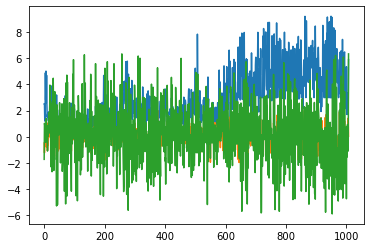

In [17]:
#impute outlier values 
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(missing_values= np.nan, strategy='mean')
train_data_ret = imputer.fit_transform(train_data_ret)
#train_data_ret = pd.DataFrame(train_data_ret)
plt.plot(train_data_ret)

print('train_data_ret', train_data_ret)

### Data Processing

In [18]:
##Delay - observation to delay timesteps
delay = 1

##Look Back - How many timesteps included
lookback = 20

##Steps - timesteps per sample
steps = 1

## NORMALIZING THE DATA ####################################
#
#
#
        
##Function to transform time-lapse data into training matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:i+look_back]
        dataX.append(a)
        dataY.append([dataset[i + look_back,-1]])
    return np.array(dataX), np.array(dataY)

## PREPARING DATA ########################################

from sklearn.preprocessing import MinMaxScaler

# normalize the dataset
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_ret = scaler.fit_transform(train_data_ret)
# split into train and test sets
train_size = int(len(train_data_ret) * 0.67)
test_size = len(train_data_ret) - train_size
train, test = train_data_ret[0:train_size,:], train_data_ret[train_size:len(train_data_ret),:]
# reshape into X=t and Y=t+1
X_train, y_train = create_dataset(train, lookback)
X_test, y_test = create_dataset(test, lookback)

#print('X_train:', X_train)
print('X Train Dimensions:', X_train.shape)

#print('y_train:', y_train)
print('y Train Dimensions:', y_train.shape)


X Train Dimensions: (655, 20, 3)
y Train Dimensions: (655, 1)


In [19]:
X_train_new = np.reshape(X_train, (X_train.shape[0], 1, 3*X_train.shape[1]))
y_test_new = np.reshape(y_test, (y_test.shape[0], 1, y_test.shape[1]))

X_test_new = np.reshape(X_test, (X_test.shape[0], 1, 3*X_test.shape[1]))
y_train_new = np.reshape(y_train, (y_train.shape[0],1, y_train.shape[1]))
    
print('X_train_shape', X_train_new.shape)
print('y_train_shape', y_train_new.shape)

X_train_shape (655, 1, 60)
y_train_shape (655, 1, 1)


Epoch 1/20
655/655 - 1s - loss: 0.1315
Epoch 2/20
655/655 - 1s - loss: 0.1243
Epoch 3/20
655/655 - 1s - loss: 0.1213
Epoch 4/20
655/655 - 1s - loss: 0.1173
Epoch 5/20
655/655 - 1s - loss: 0.1148
Epoch 6/20
655/655 - 1s - loss: 0.1134
Epoch 7/20
655/655 - 1s - loss: 0.1106
Epoch 8/20
655/655 - 0s - loss: 0.1104
Epoch 9/20
655/655 - 0s - loss: 0.1068
Epoch 10/20
655/655 - 0s - loss: 0.1055
Epoch 11/20
655/655 - 1s - loss: 0.1016
Epoch 12/20
655/655 - 1s - loss: 0.0990
Epoch 13/20
655/655 - 1s - loss: 0.0978
Epoch 14/20
655/655 - 0s - loss: 0.0954
Epoch 15/20
655/655 - 0s - loss: 0.0936
Epoch 16/20
655/655 - 1s - loss: 0.0912
Epoch 17/20
655/655 - 0s - loss: 0.0929
Epoch 18/20
655/655 - 0s - loss: 0.0846
Epoch 19/20
655/655 - 0s - loss: 0.0818
Epoch 20/20
655/655 - 1s - loss: 0.0854
Epoch 1/10
41/41 [==============================] - 0s 11ms/step - loss: 0.0789 - val_loss: 0.2690
Epoch 2/10
41/41 [==============================] - 0s 2ms/step - loss: 0.0765 - val_loss: 0.2699
Epoch 3/10
4

(<Figure size 864x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1cc34e7a100>)

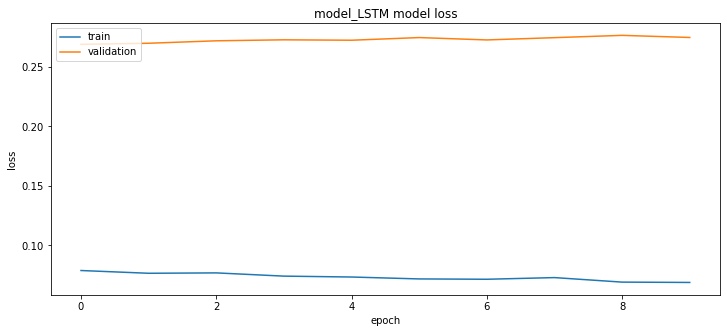

In [20]:
from tensorflow.keras.layers import Dense, LSTM, Dropout
from keras import layers
from keras.models import Sequential
from keras.optimizers import RMSprop
       
model_LSTM = Sequential()
model_LSTM.add(LSTM(units = 20, return_sequences = True, 
                    input_shape=(1, 3*lookback)))
model_LSTM.add(Dropout(0.2))
model_LSTM.add(Dense(1))
model_LSTM.compile(optimizer='rmsprop',loss='mse')
model_LSTM.fit(X_train_new, y_train_new, epochs=20, batch_size=1, verbose=2)
history = model_LSTM.fit(X_train_new, y_train_new, epochs = 10,  
                        validation_data = (X_test_new, y_test_new),
                        batch_size = 16, shuffle = False)
model_LSTM.summary()

score0 = model_LSTM.evaluate(X_test_new, y_test_new)
score1 = model_LSTM.evaluate(X_train_new, y_train_new)

print("{n:s}: Test loss: {l:3.2f}".format(n='LSTM model', l=score0))
print("{n:s}: Train loss: {l:3.2f}".format(n='LSTM model', l=score1))

plotTrain(model_LSTM, history, 'model_LSTM')

(313, 1)
(313, 1)


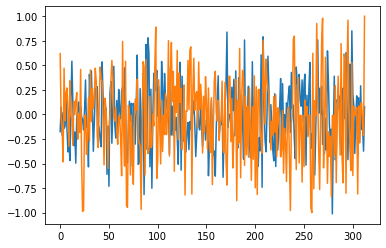

In [21]:
y_pred = model_LSTM.predict(X_test_new)
y_pred = y_pred.reshape(-1,1)
print(y_pred.shape)
print(y_test.shape)
plt.plot(y_pred)
plt.plot(y_test)

It's really hard to tell if this model is better or worse than our LSTM implementation. It shows much worse validation performance at 0.28 but a better in-sample validation at 0.06. This could be a sign of overfitting but it's rather hard to say it's definitively better or worse than our previous model.

# Out of sample evaluation

*You* should test your models out of sample.

This will be beneficial as *we* will evaluate your model out of sample using a holdout data directory.

The *holdout data directory* will be for dates that are strictly later than the latest date in the
training data directory.
- will contain 2 years of data
- you will be required to predict the latest 200 returns of AAPL for this holdout directory
- your submission *must work on the holdout directory*
    - you should assume the directory is at relative path  `./data/holdout`

So you might want to create your own validation/test data (from the training data directory) that mimics
what the holdout data directory will contain.

It is up to you to decide on the out of sample data that you use for model development.


# Suggestions for  getting started

The problem we presented to you is unstructured and not precisely defined in full detail.

- Start by defining, in detail,  the problem that you will attempt to solve
    - Do you view this as a Regression task ?  A Classification task
    - Justify your choice
~ Define the Performance Metric that you think is appropriate
    - Justify your choice

- Start with a simple model, using only data from AAPL (few features)
    - Use the model to get a feel for the problem
    - Will be a good baseline
    - Will help you form new hypotheses to test
        - may guide the choice of additional features
- Create new models iteratively
    - Train and evaluate a "simpler" model
    - Evalute performance
    - Perform error analysis
    - Propose a new "less simple" model
        - add as many features as you like, from any file in the directory

- Be disciplined in your process: avoid repeating code
    - It will be easier if you have a single piece of code that works for
        - the training directory
        - the test directory (that you might choose to create)
        - the holdout directory
    - This will
        - simplify your process
        - help ensure that your submission will work on the holdout directory !
   

# Warning: Avoid looking into the future !

Obviously, you should not use knowledge of the future to predict future prices.

But it is surprisingly easy to inadvertantly do so !  For example:
- when standardizing a data set: you might compute averages and standard deviations over the full range of dates
    - this means that the earliest dates have implicit knowledge of later dates
        - for example, suppose the mean increases after 10 days
        - the observations of the first 9 days *should not know* that the mean of the entire data range is different than what is available from earlier observations

# Evaluating your model
   
Your goals
- demonstrate that your models can predict in-sample (based on training only) somewhat successfully
    - this is easier than predicting out of sample
    - this will show that your model has "learned" something
- evaluate your model out of sample using the validation/test set you created
- run multiple experiments to try to improve out of sample prediction
- present a "final model" which we will evaluate with a holdout dataset
     - The holdut dataset will be identical in structure to the full data set we provide
     - *BUT* the dates will be strictly after the dates in the full dataset.

# Final reminder: document your thought process

**The key to getting a good grade** is to
- document everything you do
- justify the many choices you will have to make -- use data and intuition to back up your statements
- report on failed theories/experiments
    - it shows the amount of effort you expended
    - tell us
        - why you thought it was a good idea to try
        - what you learned from the failure
        - how the failure led you to try something different
        
The out of sample prediction is hard -- you may or may not do well.

What is important is to see how you tried to improve and how failure as well as success led to
better experiments.

## Final Training Data Processing

For the final model submission, we train our data over the last 6 years of the data as to provide the most data. We proceed in a similiar fashion as before. 

            AAPL_Ret
Dt                  
2010-01-04  1.556475
2010-01-05  0.172923
2010-01-06 -1.590768
2010-01-07 -0.184948
2010-01-08  0.664754


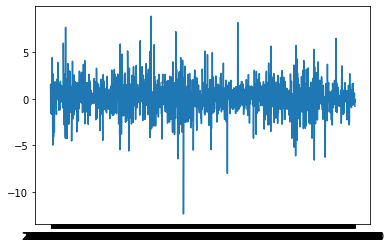

In [22]:
#tickers is a list of tickers
#attrs is a list of data attributes
tickers = ['AAPL']
indx = ""
attrs = ['Adj Close']

##DATA IMPORT
DATA_DIR = './Data/train'
if not os.path.isdir(DATA_DIR):
    DATA_DIR  = "../resource/asnlib/publicdata/data"

dateAttr = "Dt"

use_cols =  attrs.copy()
use_cols.insert(0, dateAttr)

# Read the CSV files
dfs = []
for ticker_num, ticker in enumerate(tickers):
    ticker_file = os.path.join(DATA_DIR, "{t}.csv".format(t=ticker) )
    ticker_df = pd.read_csv(ticker_file, index_col=dateAttr, usecols=use_cols)

    # Rename attributes with ticker name
    rename_map = { orig:  ticker + "_" + orig.replace(" ", "_") for orig in ticker_df.columns.to_list() }
    ticker_df = ticker_df.rename(columns=rename_map)

    dfs.append(ticker_df)

data_df = pd.concat( dfs, axis=1)

start_dt = "2010-01-04"
end_dt = "2016-12-30"

def getReturns(df, ticker, start_dt, end_dt):
    '''
    Return the day over day percent changes of adjusted price
    '''
    ## We find start and end index in a similar fashion as before
    start =max(df.index.get_loc(start_dt) - 1,0)
    end = min(df.index.get_loc(end_dt)+1,len(df))
    data = df[start:end]
    ret = pd.DataFrame()
    ret[ticker + '_Ret'] = data[ticker + '_Adj_Close'].pct_change()*100
    return ret

def getSpread(df, start_dt, end_dt):
    '''
    Return the daily spread of the prices 
    '''
    ## We find start and end index in a similar fashion as before
    start =max(df.index.get_loc(start_dt) - 1,0)
    end = min(df.index.get_loc(end_dt)+1,len(df))
    data = pd.DataFrame()
    #data['SPY_Spread'] = df['SPY_High'] - df['SPY_Low']
    data['AAPL_Spread'] = df['AAPL_High'] - df['AAPL_Low']
    return data[start:end]

data = getReturns(data_df, 'AAPL', start_dt, end_dt)

data = data[start_dt:]
print(data.head())
plt.plot(data)


In [23]:
from numpy import percentile

def removeOutliers(data, index):
    q25, q75 = percentile(data[index], 25), percentile(data[index], 75)
    iqr = q75 - q25
    print('Percentiles: 25th=%.3f, 75th=%.3f, IQR=%.3f' % (q25, q75, iqr))
    # calculate the outlier cutoff
    cut_off = iqr * 1.5
    lower, upper = q25 - cut_off, q75 + cut_off
    # identify outliers
    outliers_id = [i for i in range(len(data.index)) if data[index][i] < lower 
                   or data[index][i] > upper]
    print('Identified outliers: %d' % len(outliers_id))

    # remove outliers
    for i in range(len(data.index)):
        if i in outliers_id:
            data[index][i] = math.nan
    return data

data = removeOutliers(data, 'AAPL_Ret')

Percentiles: 25th=-0.740, 75th=1.034, IQR=1.775
Identified outliers: 73


X Train Dimensions: (1742, 20, 1)
y Train Dimensions: (1742, 1)
X_train_shape (1742, 1, 20)
y_train_shape (1742, 1, 1)


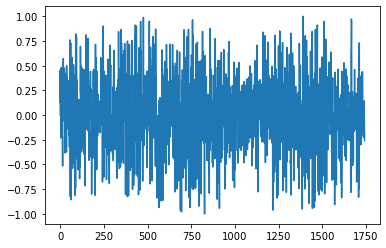

In [24]:
#impute outlier values 
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(missing_values= np.nan, strategy='mean')
data = imputer.fit_transform(data)

##Delay - observation to delay timesteps
delay = 1

##Look Back - How many timesteps included
lookback = 20

##Steps - timesteps per sample
steps = 1

## NORMALIZING THE DATA ####################################
#
#
#
        
##Function to transform time-lapse data into training matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:i+look_back]
        dataX.append(a)
        dataY.append([dataset[i + look_back,-1]])
    return np.array(dataX), np.array(dataY)

## PREPARING DATA ########################################

from sklearn.preprocessing import MinMaxScaler

# normalize the dataset
scaler = MinMaxScaler(feature_range=(-1, 1))
data = scaler.fit_transform(data)
# reshape into X=t and Y=t+1
X_train, y_train = create_dataset(data, lookback)

#print('X_train:', X_train)
print('X Train Dimensions:', X_train.shape)

#print('y_train:', y_train)
print('y Train Dimensions:', y_train.shape)

X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
y_train = np.reshape(y_train, (y_train.shape[0],1, y_train.shape[1]))
    
print('X_train_shape', X_train.shape)
print('y_train_shape', y_train.shape)

plt.plot(y_train.reshape(-1,))

## Final Submission

In [25]:
import os
from tensorflow.keras.models import load_model

modelName = "final_model"
model_path = os.path.join(".", modelName)

def saveModel(model, model_path): 
    try:
        os.makedirs(model_path)
    except OSError:
        print("Directory {dir:s} already exists, files will be over-written.".format(dir=model_path))
        
    # Save JSON config to disk
    json_config = model.to_json()
    with open(os.path.join(model_path, 'config.json'), 'w') as json_file:
        json_file.write(json_config)
    # Save weights to disk
    model.save_weights(os.path.join(model_path, 'weights.h5'))
    
    print("Model saved in directory {dir:s}; create an archive of this directory and submit with your assignment.".format(dir=model_path))
    
def loadModel(model_path):
    # Reload the model from the 2 files we saved
    with open(os.path.join(model_path, 'config.json')) as json_file:
        json_config = json_file.read()
    model = tf.keras.models.model_from_json(json_config)
    model.load_weights(os.path.join(model_path, 'weights.h5'))
    
    return model

def MyModel(test_dir, model_path):
    # YOU MAY NOT change model after this statement !
    model = loadModel(model_path)
    
    # It should run model to create an array of predictions; we initialize it to the empty array for convenience
    predictions = []
    
    # We need to match your array of predictions with the examples you are predicting
    # The array below (ids) should have a one-to-one correspondence and identify the example your are predicting
    # For Bankruptcy: the Id column
    # For Stock prediction: the date on which you are making a prediction
    ids = []
    
    # YOUR CODE GOES HERE
    X_hold = pd.read_csv(test_dir)
    X_hold = X_hold[301:]
    predictions = model.predict(X_hold)
    
    ids = X_hold.index[301:]
    
    return predictions, ids

# Assign to variable my_model the model that is your final model (the one  you will be evaluated on)
my_model = Sequential()
my_model.add(LSTM(units = 20, return_sequences = True, 
                    input_shape=(1, lookback)))
my_model.add(Dropout(0.2))
my_model.add(Dense(1))
my_model.compile(optimizer='rmsprop',loss='mse')
my_model.fit(X_train, y_train, epochs=30, batch_size=1, verbose=2)

saveModel(my_model, model_path)

holdout_dir = os.path.join(".", "Data", "holdout")
predicts = MyModel(holdout_dir, model_path)

Epoch 1/30
1742/1742 - 1s - loss: 0.1380
Epoch 2/30
1742/1742 - 1s - loss: 0.1344
Epoch 3/30
1742/1742 - 1s - loss: 0.1339
Epoch 4/30
1742/1742 - 1s - loss: 0.1329
Epoch 5/30
1742/1742 - 1s - loss: 0.1326
Epoch 6/30
1742/1742 - 1s - loss: 0.1324
Epoch 7/30
1742/1742 - 1s - loss: 0.1318
Epoch 8/30
1742/1742 - 1s - loss: 0.1317
Epoch 9/30
1742/1742 - 1s - loss: 0.1310
Epoch 10/30
1742/1742 - 1s - loss: 0.1304
Epoch 11/30
1742/1742 - 1s - loss: 0.1295
Epoch 12/30
1742/1742 - 1s - loss: 0.1287
Epoch 13/30
1742/1742 - 1s - loss: 0.1300
Epoch 14/30
1742/1742 - 1s - loss: 0.1284
Epoch 15/30
1742/1742 - 1s - loss: 0.1280
Epoch 16/30
1742/1742 - 1s - loss: 0.1274
Epoch 17/30
1742/1742 - 1s - loss: 0.1278
Epoch 18/30
1742/1742 - 1s - loss: 0.1267
Epoch 19/30
1742/1742 - 1s - loss: 0.1260
Epoch 20/30
1742/1742 - 1s - loss: 0.1259
Epoch 21/30
1742/1742 - 1s - loss: 0.1251
Epoch 22/30
1742/1742 - 1s - loss: 0.1255
Epoch 23/30
1742/1742 - 1s - loss: 0.1270
Epoch 24/30
1742/1742 - 1s - loss: 0.1246
E

FileNotFoundError: [Errno 2] File .\Data\holdout does not exist: '.\\Data\\holdout'

In [ ]:
print('Done')